In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
import matplotlib.ticker as tick
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

### Read data

In [5]:
# input sample weeks (each Saturday)
# weeks = [191012, 191019, 191026, 191102]
weeks = [191005, 191012, 191019] # 1 sample week

# url of data source
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'

# input interested lines (refer to 'Remote-Booth-Station.xls' for exact station names)
lines = ['A','L']

# get data of interested stations
# note these lines may take a while to run
df_list = []
for week in weeks:
    df_temp = pd.read_csv(url.format(week))    
    ind = (df_temp['UNIT'] == None)
    print('week read: ', week) # print out week to know how far we have gone
    for line in lines:
        ind = (ind | df_temp['LINENAME'].str.contains(line))
        print('  line read: ', line) # also print out station to know how far we have gone
    df_list.append(df_temp.loc[ind])

week read:  191005
  line read:  A
  line read:  L
week read:  191012
  line read:  A
  line read:  L
week read:  191019
  line read:  A
  line read:  L


In [6]:
# create a dataframe from the data
mta_df = pd.concat(df_list)
mta_df.sort_values(by = ['STATION'], inplace = True)
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
32246,H007,R248,00-03-01,1 AV,L,BMT,10/07/2019,12:00:00,REGULAR,2510709,1079324
32393,H008,R248,01-00-00,1 AV,L,BMT,10/12/2019,12:00:00,REGULAR,298560,4912426
32392,H008,R248,01-00-00,1 AV,L,BMT,10/12/2019,08:00:00,REGULAR,298560,4912426
32391,H008,R248,01-00-00,1 AV,L,BMT,10/12/2019,04:00:00,REGULAR,298560,4912426
32390,H008,R248,01-00-00,1 AV,L,BMT,10/12/2019,00:00:00,REGULAR,298560,4912426


### Calculate Entries and Exits per Station

In [7]:
# this section calculates No. of Entries and Exits for each turnstile at a same-day level
temp_d = defaultdict(list)
temp_d1 = defaultdict(list)
turnstile_d = {}
turnstile_d1 = {}

# collapse data to a same-day level
for row in mta_df.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    exits = row[11]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(entries)
    temp_d1[k].append(exits)
    
for key, value in temp_d.items():
    entry = abs(max(value) - min(value)) # (max - min) of a day
    turnstile_d[key] = [entry]
for key, value in temp_d1.items():
    exit = abs(max(value) - min(value)) # (max - min) of a day
    turnstile_d1[key] = [exit]
    
# form a dataframe from dictionary
dict_df = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df.rename(columns = {0:'Entries'}, inplace=True)
dict_df1 = pd.DataFrame.from_dict(turnstile_d1, orient='index')
dict_df1.rename(columns = {0:'Exits'}, inplace=True)

dict_df['Exits'] = dict_df1['Exits']
dict_df

,Entries,Exits
"(H007, R248, 00-03-01, 1 AV, L, 10/07/2019)",639,305
"(H008, R248, 01-00-00, 1 AV, L, 10/12/2019)",0,0
"(H007, R248, 00-03-02, 1 AV, L, 10/18/2019)",1231,91
"(H007, R248, 00-03-02, 1 AV, L, 10/17/2019)",1251,97
"(H007, R248, 00-03-02, 1 AV, L, 10/16/2019)",1207,106
...,...,...
"(N094, R029, 01-00-03, WORLD TRADE CTR, 23ACE, 09/28/2019)",2,6
"(N094, R029, 01-00-01, WORLD TRADE CTR, 23ACE, 10/04/2019)",1525,3308
"(N094, R029, 01-00-02, WORLD TRADE CTR, 23ACE, 09/28/2019)",2,8
"(N094, R029, 01-00-02, WORLD TRADE CTR, 23ACE, 09/29/2019)",0,0


In [8]:
# split keys for better reference
turnstile_df = pd.DataFrame(columns=[])
turnstile_df['CA'] = [row[0][0] for row in dict_df.itertuples()]
turnstile_df['unit'] = [row[0][1] for row in dict_df.itertuples()]
turnstile_df['scp'] = [row[0][2] for row in dict_df.itertuples()]
turnstile_df['station'] = [row[0][3] for row in dict_df.itertuples()]
turnstile_df['linename'] = [row[0][4] for row in dict_df.itertuples()]
turnstile_df['date'] = [row[0][5] for row in dict_df.itertuples()]
turnstile_df['entries'] = [row[1] for row in dict_df.itertuples()]
turnstile_df['exits'] = [row[2] for row in dict_df.itertuples()]
turnstile_df.head()

,CA,unit,scp,station,linename,date,entries,exits
0,H007,R248,00-03-01,1 AV,L,10/07/2019,639,305
1,H008,R248,01-00-00,1 AV,L,10/12/2019,0,0
2,H007,R248,00-03-02,1 AV,L,10/18/2019,1231,91
3,H007,R248,00-03-02,1 AV,L,10/17/2019,1251,97
4,H007,R248,00-03-02,1 AV,L,10/16/2019,1207,106


### Check Data

In [47]:
# take a look at each station's top 5 stations' ridership
for line in lines:
    tstile = pd.pivot_table(turnstile_df[turnstile_df['linename'].str.contains(line)], values='entries', index=['date'], columns=['station'], aggfunc=np.sum)
    checker = tstile.sum()/len(weeks)
    checker.sort_values(ascending = False, inplace = True)
    print('------')
    print('line ',line,':')
    print(checker.head(5))

------
line  A :
station
59 ST COLUMBUS    16976861.33
34 ST-PENN STA     1095984.67
BEACH 36 ST         756485.67
42 ST-PORT AUTH     576390.00
FULTON ST           514259.67
dtype: float64
------
line  L :
station
14 ST-UNION SQ   550298.67
14 ST            350087.00
BEDFORD AV       141241.33
8 AV             128808.33
MYRTLE-WYCKOFF   105205.00
dtype: float64


#### 59 ST COLUMBUS is a problematic data point with entries 10 times higher than others.

### Plot Entries per Week for Each Station and Each Line

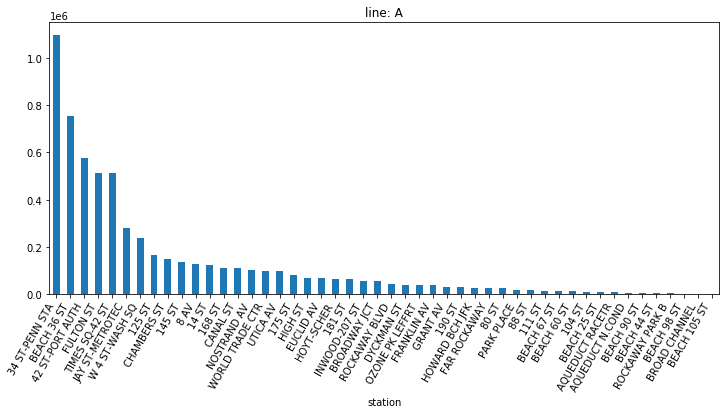

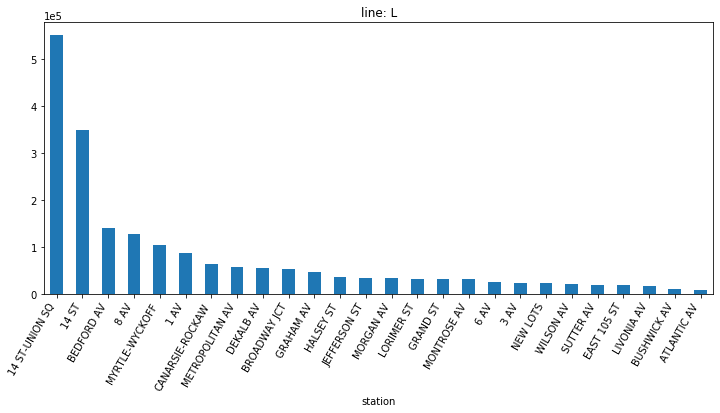

In [58]:
# plot the entries in descending ordr
for line in lines:
    tstile = pd.pivot_table(turnstile_df[turnstile_df['linename'].str.contains(line)], values='entries', index=['date'], columns=['station'], aggfunc=np.sum)
    # from the above analysis, drop '59 ST COLUMBUS'. 
    if line == 'A':
        tstile.drop(columns=['59 ST COLUMBUS'], inplace = True)
    tstile_weekly = tstile.sum()/len(weeks)
    tstile_weekly.sort_values(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize = (12, 5))
    tstile_weekly.plot.bar(ax = ax)
    ax.ticklabel_format(axis='y', scilimits=(0,5))
    plt.xticks(rotation=60, ha='right')
    ax.set_title('line: ' + line)

### Analyze Daily Dynamics of Selected Stations

In [59]:
# How about the daily dynamics of these stations? Choose 3 of them to take a look
# stations = turnstile_df['station'].unique()
stations = ['34 ST-PENN STA', '42 ST-PORT AUTH', 'TIMES SQ-42 ST']

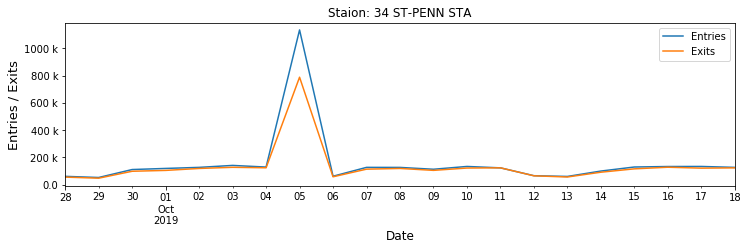

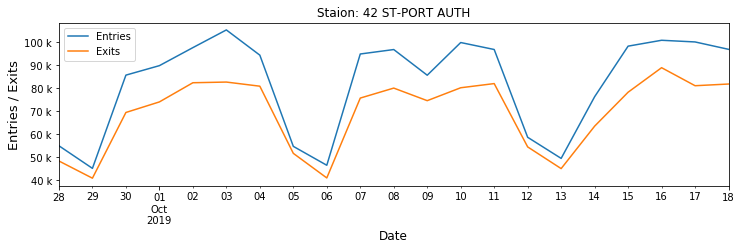

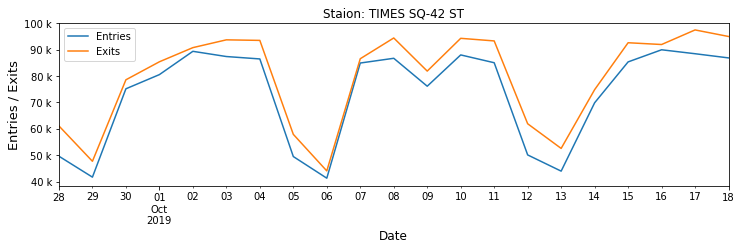

In [60]:
# convert date string to datetime object for plot
turnstile_df['date'] = pd.to_datetime(turnstile_df['date'])
tstile_dynamic = turnstile_df.groupby(['station','date']).sum().sort_values(by=['station', 'date'],ascending=False)
tstile_dynamic.reset_index(inplace=True)
tstile_dynamic.set_index('date', inplace = True)
tstile_dynamic.sort_index(ascending=True, inplace = True)

legend = ['Entries', 'Exits']

def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return '{:.0f} M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{:.0f} k'.format(val)
    else:
        return tick_val

for station in stations:
    f, ax = plt.subplots(figsize = (12,3))
    tstile_dynamic[tstile_dynamic['station'] == station].plot(ax = ax, y = 'entries')
    tstile_dynamic[tstile_dynamic['station'] == station].plot(ax = ax, y = 'exits')
    ax.legend(legend)
    ax.set_xlabel('Date',size = 12)
    ax.set_ylabel('Entries / Exits',size = 13)
    ax.set_title('Staion: ' + station)    
    #ax.ticklabel_format(axis='y', scilimits=(0,6))
    ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

### Calculate Average Entries and Exits for Each Station

In [63]:
# calculate weekly average turnstile usage
pd.to_datetime(turnstile_df['date'])
turnstile_df.groupby(['linename', 'station']).sum().sort_values(by='entries',ascending=False).head(10)

turnstile_sum_df = turnstile_df.groupby(['linename','station']).sum()
turnstile_sum_df = turnstile_sum_df.sort_values(by='entries',ascending=False)
turnstile_sum_df.reset_index(inplace=True)

turnstile_sum_df['ave_week'] = turnstile_sum_df['entries']/len(weeks)
turnstile_sum_df['ave_week'] = turnstile_sum_df['ave_week'].astype(int)
turnstile_sum_df.head()

,linename,station,entries,exits,ave_week
0,1ABCD,59 ST COLUMBUS,50930584,17870615,16976861
1,ACE,34 ST-PENN STA,2415593,2000682,805197
2,A,BEACH 36 ST,2269457,1199373,756485
3,456LNQRW,14 ST-UNION SQ,1650896,1689609,550298
4,2345ACJZ,FULTON ST,1542779,1400102,514259
